In [1]:
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from transforms import *
from train import *
from utils import *
from models import *
from dataset import *
from learner import *

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn

import optuna
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

EPOCHS = 50
LEARNING_RATE = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using: {device}')


preprocess = PreprocessPipelineRNN(target_sr=16000)
transforms = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=3840, hop_length=1024, n_mels=192, center=False),
    torchaudio.transforms.AmplitudeToDB(stype="power")
])
augments = RandomCombine(0.5,max_files=4)


train_dir = os.path.join(Path(os.getcwd()).parent, "data/raw/IRMAS_Training_Data")
valid_dir = os.path.join(Path(os.getcwd()).parent, "data/raw/IRMAS_Validation_Data")


train_dl = get_loader(train_dir, preprocess, augments, 
                      transforms, bs=16, rnn=True, device=device, 
                      subset="train")

valid_dl = get_loader(valid_dir, preprocess, augments=None,
                      transforms=transforms, bs=16, rnn=True, 
                      device=device, 
                      subset="valid")


model = RNN(128,64,3,11, device=device)
optimizer = optim.Adam
loss_fn = FocalLoss()

learn = Learner(train_dl, valid_dl, model, loss_fn)
#learn.fit(50, LEARNING_RATE, optimizer)

/home/kpintaric/LUMEN-Data-Science-IRMAS/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using: cpu


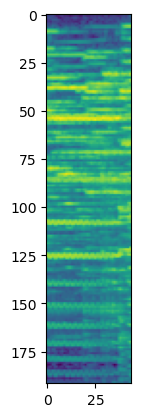

In [2]:
plt.imshow(train_dl.dataset[80][0].squeeze())

In [3]:
mfcc = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 2056, "hop_length": 2048, "n_mels": 128, "center": False},
    log_mels=True
)

In [4]:
sample = preprocess(*torchaudio.load(train_dl.dataset.files[100]))
ipd.Audio(sample, rate=16000)

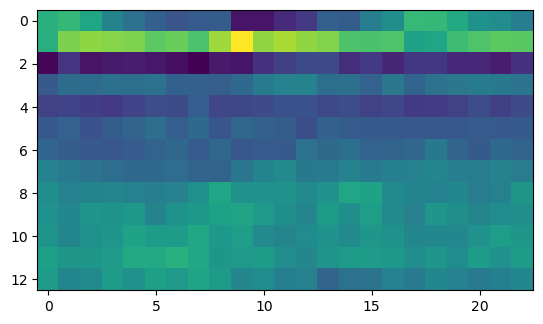

In [5]:
mfcc_sample = mfcc(sample)
plt.imshow(mfcc_sample.squeeze())

(array([12., 21., 47., 51., 76., 63., 10.,  9.,  9.,  1.]),
 array([-17.77242661, -13.89374447, -10.01506233,  -6.13638067,
         -2.25769877,   1.62098312,   5.49966526,   9.3783474 ,
         13.25702858,  17.13571167,  21.01439285]),
 <BarContainer object of 10 artists>)

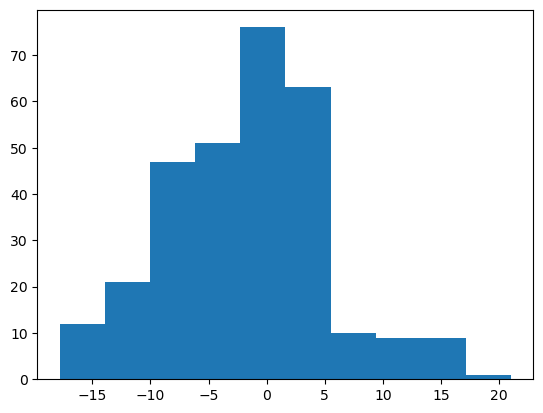

In [6]:
plt.hist(mfcc_sample.ravel())

In [7]:
a = torch.Tensor([5,4,3])
b = torch.Tensor([5,4])
a+b

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0

In [9]:
import torch

# create two tensors with the same shape
tensor1 = torch.randn(3, 3)
tensor2 = torch.randn(3, 3)

# define the shift amount
x = 1

# create a zero tensor with the same shape as tensor1 and tensor2
result_tensor = torch.zeros_like(tensor1)

# copy tensor1 into the result tensor, starting from the beginning
result_tensor[:,:] = tensor1[:,:]

# copy tensor2 into the result tensor, starting from the x-th index
result_tensor[:,x:] += tensor2[:,:-x]

print(result_tensor)

tensor([[-0.3798,  0.0977, -0.6164],
        [ 0.6528, -1.3567, -1.4328],
        [-1.4763, -2.9224,  0.8759]])


In [10]:
import torch

# create two tensors with the same shape
tensor1 = torch.randn(3, 3)
tensor2 = torch.randn(3, 3)

# define the shift amount
x = 2

# calculate the amount of padding needed for tensor2
padding = [(0, 0), (x, 0)]  # pad the second dimension of tensor2 with x zeros at the beginning

# pad tensor2 with zeros
padded_tensor2 = torch.nn.functional.pad(tensor2, padding, mode='constant', value=0)

# perform the sum of tensor1 and padded_tensor2
result_tensor = torch.add(tensor1, padded_tensor2)

print(result_tensor)

TypeError: pad(): argument 'pad' (position 2) must be tuple of ints, not list

In [18]:
sample.shape

torch.Size([1, 48000])

In [24]:
torch.nn.functional.pad(sample, (48000,0), "constant", 0)

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0357,  0.0118,  0.0361]])

In [ ]:
def shift_signal(signal, shift_amount):

    return F.pad(signal, (shift_amount, 0), "constant", 0)